#Using the CIFAR-10 dataset to image classification

This colab notebook contains the code we used to our problem of image classification. Our Medium article can be found here(adicionar link).

##Importing and installing libs and datasets

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import time
import datetime
import pytz
from mlxtend.plotting import plot_decision_regions
import seaborn as sns


%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=300c9bc6d09d45e7d02281e07333e392acd3b25cf04487c34909fc57cb84ee04
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=e533f4cc4b1c305fe16d325dd936dca496dbe635384b58f1f59128d2df74a904
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from keras.datasets import cifar10
(X_train_orig, Y_train_orig) , (X_test_orig, Y_test_orig) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


## Preparing and normalizing the dataset


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[Text(0, 0, 'airplane'),
  Text(0, 0, 'automobile'),
  Text(0, 0, 'bird'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'deer'),
  Text(0, 0, 'dog'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'ship'),
  Text(0, 0, 'truck')]]

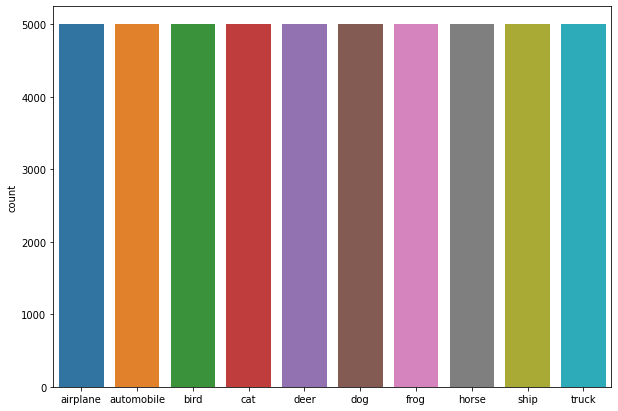

In [ ]:
Y_train_orig = Y_train_orig.flatten()
Y_test_orig = Y_test_orig.flatten()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,7))
p = sns.countplot(Y_train_orig.flatten())
p.set(xticklabels=classes)

In [ ]:
np.isnan(X_train_orig).any()
np.isnan(X_test_orig).any()

False

4


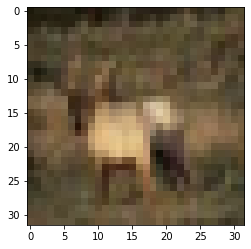

In [ ]:
index = 3
plt.imshow(X_train_orig[index])
# print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
print(Y_train_orig[index])

In [ ]:
# input_shape = (32, 32, 3)

# X_train_flatten= X_train_orig.reshape(X_train_orig.shape[0], X_train_orig.shape[1], X_train_orig.shape[2], 3)
# train_x = X_train_flatten / 255.0
# X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], X_test_orig.shape[1], X_test_orig.shape[2], 3)
# test_x = X_test_flatten / 255.0

# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)

# Normalize image vectors
train_x = X_train_flatten/255.0
test_x = X_test_flatten/255.0

#Convert training and test labels to one hot matrices

# Y_train_orig = tf.one_hot(Y_train_orig.astype(np.int32), depth=10)
# Y_test_orig = tf.one_hot(Y_test_orig.astype(np.int32), depth=10)

train_y = tf.one_hot(Y_train_orig.astype(np.int32), depth=10)
test_y = tf.one_hot(Y_test_orig.astype(np.int32), depth=10)

print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))
print(train_y[0])

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 3072)
Y_train shape: (50000, 10)
X_test shape: (10000, 3072)
Y_test shape: (10000, 10)
tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))
    print('Duration: {}s'.format(time.time() - self.begins))

In [ ]:
def print_analysis(titles,history):
  loss = ["loss", "val_loss"]
  accuracy = ["categorical_accuracy","val_categorical_accuracy"]
  f, axs = plt.subplots(1,2,figsize=(10,4))
  
  for i,item in enumerate([loss,accuracy]):
    axs[i].plot(history.history[item[0]])
    axs[i].plot(history.history[item[1]])
    axs[i].set_ylabel(item[0])
    axs[i].set_xlabel('epoch')
    axs[i].legend(['train', 'test'], loc='best')

  f.suptitle(titles, y=1.1)
  plt.tight_layout()
  plt.show()

## Instantiating the model

We are going to instantiate a Model using standard hyperparameters. After that, we are going to train the model using hyperparameter tuning, and then retrain our first model with the best hyperparameters.

### Standard Model

In [ ]:
model = tf.keras.Sequential([
                                # tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=train_x.shape[1:], activation='relu'),
                                # tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                # tf.keras.layers.MaxPooling2D(),
                                # tf.keras.layers.Dropout(0.25),

                                # tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                                # tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                # tf.keras.layers.MaxPooling2D(),
                                # tf.keras.layers.Dropout(0.25),

                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(10, activation='softmax'),
                             ])

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# # Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# # Instantiate an optimizer using Hyperparameter Tuning.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
#             loss=loss, metrics=accuracy)


history = model.fit(x=train_x,
                  y=train_y,
                  batch_size=32,
                  epochs=15,
                  validation_data=(test_x,test_y),
                  callbacks=[MyCustomCallback()],
                  verbose=2)

Training: begins at 2021-03-22 14:00:26
Epoch 1/15
1563/1563 - 23s - loss: 11.1746 - categorical_accuracy: 0.1254 - val_loss: 10.9132 - val_categorical_accuracy: 0.2133
Epoch 2/15
1563/1563 - 22s - loss: 10.9423 - categorical_accuracy: 0.1735 - val_loss: 10.7952 - val_categorical_accuracy: 0.2518
Epoch 3/15
1563/1563 - 22s - loss: 10.8109 - categorical_accuracy: 0.2045 - val_loss: 10.7024 - val_categorical_accuracy: 0.2727
Epoch 4/15
1563/1563 - 21s - loss: 10.7140 - categorical_accuracy: 0.2256 - val_loss: 10.6197 - val_categorical_accuracy: 0.2849
Epoch 5/15
1563/1563 - 21s - loss: 10.6284 - categorical_accuracy: 0.2433 - val_loss: 10.5427 - val_categorical_accuracy: 0.2971
Epoch 6/15
1563/1563 - 21s - loss: 10.5519 - categorical_accuracy: 0.2528 - val_loss: 10.4706 - val_categorical_accuracy: 0.3118
Epoch 7/15
1563/1563 - 21s - loss: 10.4829 - categorical_accuracy: 0.2626 - val_loss: 10.4017 - val_categorical_accuracy: 0.3175
Epoch 8/15
1563/1563 - 21s - loss: 10.4133 - categorical_

In [ ]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

1563/1563 [==============================] - 11s 7ms/step - loss: 9.9101 - categorical_accuracy: 0.3475
Train loss: 9.910 - acc: 0.348
313/313 [==============================] - 2s 7ms/step - loss: 9.9133 - categorical_accuracy: 0.3472
Test loss: 9.913 - acc: 0.347


### Using hyperparameter tuning to find the best hyperparameters

In [ ]:
from kerastuner.tuners import RandomSearch

# # Configure the random see for the reproducibility purposes
# tf.random.set_seed(3)

def build_model(hp):
  # Instantiate a simple classification model
  model = tf.keras.Sequential([
                                # tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=train_x.shape[1:], activation='relu'),
                                # tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                # tf.keras.layers.MaxPooling2D(),
                                # tf.keras.layers.Dropout(0.25),

                                # tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                                # tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                # tf.keras.layers.MaxPooling2D(),
                                # tf.keras.layers.Dropout(0.25),

                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(units=hp.Int('units',
                                                                   min_value=32,
                                                                   max_value=512,
                                                                   step=32), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(10, activation='softmax'),
                              ])

  # Instantiate a logistic loss function that expects integer targets
  loss = tf.keras.losses.CategoricalCrossentropy()

  # # Instantiate an accuracy metric.
  accuracy = tf.keras.metrics.CategoricalAccuracy()

  # # Instantiate an optimizer using Hyperparameter Tuning.
  optimizer = tf.keras.optimizers.SGD(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

  # configure the optimizer, loss, and metrics to monitor.
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

  # model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
  #             loss=loss, metrics=accuracy)

  return model

In [ ]:
#Using tf hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='categorical_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hp_tuning'
)

tuner.search(train_x,
             train_y, 
             epochs=15,
             verbose=2,
             batch_size=32,
             validation_data=(test_x, test_y)
)

Trial 3 Complete [00h 06m 59s]
categorical_accuracy: 0.28621000051498413

Best categorical_accuracy So Far: 0.3700699955224991
Total elapsed time: 00h 14m 08s
INFO:tensorflow:Oracle triggered exit


### Retraining the model using the best hyperparameters

In [ ]:
# print a summary of results
tuner.results_summary(num_trials=10)

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
model.fit(train_x, train_y, epochs = 20, validation_data = (test_x, test_y),batch_size=32)

In [ ]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

## Testing other parameters

In [ ]:
print("Number of parameters %.d" % model.count_params())

In [ ]:
model.summary()

In [ ]:
# example of converting an image with the Keras API
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.transform import resize

# load the image
img = load_img('air2.jpg')

# convert to numpy array
img_array = img_to_array(img)/255
img_array_res = resize(img_array, (32,32)).reshape((1, 32*32*3))

print(img_array_res.dtype)
print(img_array_res.shape)

plt.imshow(img_array)